In [1]:
import os
import sys
sys.path.append(os.path.abspath('../'))

import time
import scipy as sp
import numpy as np
import igraph as ig
import pandas as pd
from tqdm import tqdm
import networkx as nx
import NetworkingWithKuraPy as kp

from src.graph_analyzer import NetworkAnalyzer as na
from src.utils.graph_generator import GraphGenerator

# Kuramoto model on various graph model and real world networks
## Project for Bioinspired Systems 2024
---
#### 11 of December, 2024, Budapest
#### Kristóf Benedek
email: kristof.benedek@edu.bme.hu

## Introduction

Synchronization phenomena is fascinating and it occurs in our everyday life, more over it also governs numerous processes. Just think about opinion dynamics, traffic, applause, fireflies' flickering and neurons.

For different systems and dynamics several models are implemented and used. One such well-known model is the Kuramoto model. It comes in many flavours, generally building on two major variants, namely the first and second order Kuramoto model.



**The first-order Kuramoto model** describes the dynamics of $ N $ coupled oscillators. The equation is:

$$
\frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i), \quad i = 1, 2, \dots, N
$$

- **Variables**:
  - $ \theta_i $: The phase of the $ i $-th oscillator.
  - $ \omega_i $: The natural frequency of the $ i $-th oscillator, drawn from a distribution (often Gaussian or uniform).
  - $ K $: Coupling strength that determines how strongly the oscillators interact.
  - $ N $: Total number of oscillators.

#### **Interpretation**:
1. **Natural Frequency** ($ \omega_i $):
   - Each oscillator has a natural tendency to oscillate at its own frequency.
2. **Coupling Term** ($ \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i) $):
   - Oscillators influence each other through this term. If $ K > 0 $, they tend to synchronize by pulling their phases closer.
3. **Behavior**:
   - At low coupling ($ K $), oscillators remain desynchronized.
   - At high coupling, synchronization emerges, where oscillators align their phases or move coherently.
   - A phase transition from incoherence to partial or full synchronization occurs as $ K $ increases.

This first-order equation is widely used to study synchronization in coupled systems as brain, Jospehson junctions, opinion dynamics.


**The second-order Kuramoto model** includes an inertia term, which adds dynamics for systems where momentum or damping effects are significant. The equation is:

$$
m \frac{d^2 \theta_i}{dt^2} + \gamma \frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i), \quad i = 1, 2, \dots, N
$$

- **Additional Variables**:
  - $ m $: Inertia or mass of the oscillators.
  - $ \gamma $: Damping coefficient.

#### **Interpretation**:
1. **Inertia Term** ($ m \frac{d^2\theta_i}{dt^2} $):
   - Introduces oscillatory inertia, relevant in systems where the oscillators resist changes to their velocities.
   - Examples: Power grids, mechanical oscillators, or systems with delayed adjustments.
2. **Damping Term** ($ \gamma \frac{d\theta_i}{dt} $):
   - Accounts for dissipation of energy, reducing the oscillators' velocities over time.
3. **Behavior**:
   - For low damping ($ \gamma $), the system can exhibit oscillatory or chaotic dynamics.
   - At high damping, the model simplifies to the first-order Kuramoto model.
   - The system can show richer synchronization behavior, such as frequency clustering or hysteresis effects.

---

### **Key Differences Between First and Second-Order Models**

| Aspect                  | First-Order Model                              | Second-Order Model                              |
|-------------------------|-----------------------------------------------|------------------------------------------------|
| Dynamics                | Simplified, phase-only evolution.             | Includes inertia and velocity effects.         |
| Applicability           | Systems where inertia is negligible.          | Systems with momentum or delayed adjustments.  |
| Synchronization Behavior| Phase transitions from incoherence to sync.    | Richer dynamics: oscillations, clustering.     |
| Complexity              | Easier to analyze and simulate.               | More complex but realistic in some contexts.   |

Both models have been widely used to study synchronization in various systems, from neuroscience to power grid stability and social dynamics.

## Aims

In this work I will attempt to investigate how synschronization dynamics is affected by the structure of the underlying system. This will mean in practice, that we will generate some synthetic graphs via some well-known methods such as:
- Erdős-Rényi
- Small-World
- Barabási-Albert (preferential attachement)
- Stohastic Block Method (SBM)

We will compare the synchronization dynamics with a few real world examples, such as:
- a road network of a city
- some brain netwrok
where the application of the Kuramoto model can be motivated.

In the first part we will compute some properties of the graphs, such as:
- centrality measures (mainly betweeness)
- degree distributions
- community structure (one method only: infomap) 
- diameter of the graph
- average degree
- clustering coefficient
- number of triangles

In the second part, we will simulate the Kuramoto model on these graphs and observe the synchronization dynamics. We will use the Kuramoto model implemented in the NetworkingWithKuraPy library developed by me and a colleague of mine. This repo is not yet public as it is still under development, for accessing or viewing the code please contact me.

---

## Part I - Analyzing the graphs



In [2]:
gen = GraphGenerator

graphs_collector = {}

# Erdős-Rényi graph
erdos_renyi_graph = gen.generate_erdos_renyi(n=1000, m=1700)
graphs_collector["erdos_renyi"] = erdos_renyi_graph
print("Erdős-Rényi graph generated with", len(erdos_renyi_graph.vs), "vertices and", len(erdos_renyi_graph.es), "edges.")

# Small-World graph
small_world_graph = gen.generate_small_world(n=1000, k=4, p=0.2)
graphs_collector["small_world"] = small_world_graph
print("Small-World graph generated with", len(small_world_graph.vs), "vertices and", len(small_world_graph.es), "edges.")

# Barabási-Albert graph
barabasi_albert_graph = gen.generate_barabasi_albert(n=1000, m=2)
graphs_collector["barabasi_albert"] = barabasi_albert_graph
print("Barabási-Albert graph generated with", len(barabasi_albert_graph.vs), "vertices and", len(barabasi_albert_graph.es), "edges.")

# Stochastic Block Model graph
p1 = [[0.1, 0.01, 0.01, 0.01, 0.01], 
        [0.1, 0.01, 0.01, 0.01, 0.01],
        [0.1, 0.01, 0.01, 0.01, 0.01],
        [0.1, 0.01, 0.01, 0.01, 0.01],
        [0.1, 0.01, 0.01, 0.01, 0.01]]

p2 = np.random.uniform(0.0001, 0.0065,(6,6))
p2 = (p2+p2.T)/2
np.fill_diagonal(p2, np.random.uniform(0.005, 0.015, 6))
sbm_graph = gen.generate_stochastic_block_model(n=1000,sizes=[50, 150, 200, 225, 125, 250], 
                                                p_matrix=p2)
graphs_collector["sbm"] = sbm_graph
print("Stochastic Block Model graph generated with", len(sbm_graph.vs), "vertices and", len(sbm_graph.es), "edges.")

brain_graph = ig.Graph(edges=np.loadtxt("other_nets/brain/bn-mouse-kasthuri_graph_v4/bn-mouse-kasthuri_graph_v4.edges", dtype =int), directed = False)
graphs_collector["mouse_brain"] = brain_graph
print(f"Mouse Brain graph generated with {len(brain_graph.vs)} veritces and {len(brain_graph.es)} edges")

power_graph = ig.Graph(edges=np.loadtxt("other_nets/power/power-US-Grid/power-US-Grid.mtx", dtype =int, comments="%"), directed = False)
graphs_collector["power_network"] = power_graph
print(f"Power Network graph generated with {len(power_graph.vs)} veritces and {len(power_graph.es)} edges")

Erdős-Rényi graph generated with 1000 vertices and 1700 edges.
Small-World graph generated with 1000 vertices and 2000 edges.
Barabási-Albert graph generated with 1000 vertices and 1997 edges.
Stochastic Block Model graph generated with 1000 vertices and 2302 edges.
Mouse Brain graph generated with 1029 veritces and 1700 edges
Power Network graph generated with 4942 veritces and 6594 edges


In [3]:
p2 = np.random.uniform(0, 0.2,(5,5))
p2 = (p2+p2.T)/2
np.fill_diagonal(p2, np.random.uniform(0.005, 0.02, 5))
p2

array([[0.00974838, 0.11673636, 0.0841147 , 0.12390374, 0.11864093],
       [0.11673636, 0.01562306, 0.15058943, 0.09466257, 0.07862695],
       [0.0841147 , 0.15058943, 0.01939999, 0.08708552, 0.07907441],
       [0.12390374, 0.09466257, 0.08708552, 0.01061025, 0.08056604],
       [0.11864093, 0.07862695, 0.07907441, 0.08056604, 0.01827356]])

In [4]:
pd.read_csv("road_nets/kolozsvar_edges.csv").columns

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'width',
       'reversed', 'length', 'geometry', 'ref', 'access', 'bridge', 'junction',
       'tunnel', 'area'],
      dtype='object')

In [5]:
pd.read_csv("road_nets/kolozsvar_nodes.csv").columns

Index(['y', 'x', 'street_count', 'highway', 'geometry'], dtype='object')

In [6]:
r = na.get_basic_properties(erdos_renyi_graph)
r['density']

0.0034034034034034033

In [7]:
erdos_renyi_graph.ecount()

1700

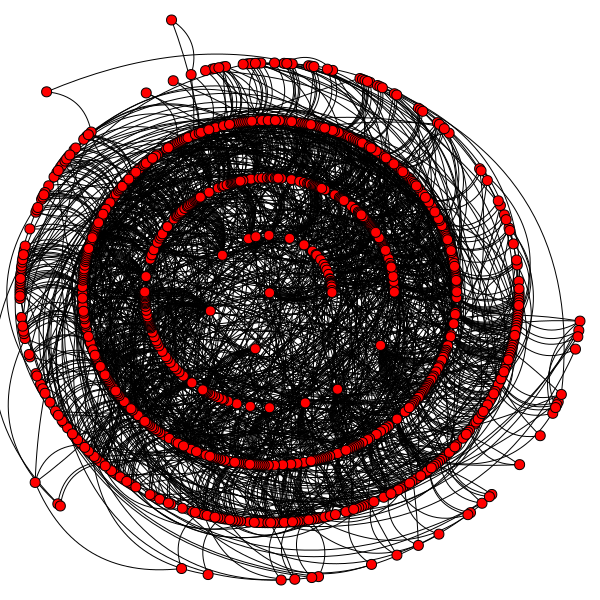

In [8]:
na.plot_graph(barabasi_albert_graph, savename='1.png', layout='rt_circular')


In [9]:
graph_result_container = {}
for name , graph in graphs_collector.items():
    print(name)
    result = na.get_basic_properties(graph)
    graph_result_container[name] = result

    na.plot_graph(graph, savename=f'graphs/{name}.png', layout='rt_circular')
    

erdos_renyi
small_world
barabasi_albert
sbm
mouse_brain
power_network


/home/syntaxerror/.pyenv/versions/3.12.6/lib/python3.12/site-packages/planarity/planarity_functions.py:8: UserWarning: ignoring parallel edge 0-2
  return planarity.PGraph(graph).is_planar()
/home/syntaxerror/.pyenv/versions/3.12.6/lib/python3.12/site-packages/planarity/planarity_functions.py:8: UserWarning: ignoring parallel edge 0-48
  return planarity.PGraph(graph).is_planar()
/home/syntaxerror/.pyenv/versions/3.12.6/lib/python3.12/site-packages/planarity/planarity_functions.py:8: UserWarning: ignoring parallel edge 0-147
  return planarity.PGraph(graph).is_planar()
/home/syntaxerror/.pyenv/versions/3.12.6/lib/python3.12/site-packages/planarity/planarity_functions.py:8: UserWarning: ignoring parallel edge 0-279
  return planarity.PGraph(graph).is_planar()
/home/syntaxerror/.pyenv/versions/3.12.6/lib/python3.12/site-packages/planarity/planarity_functions.py:8: UserWarning: ignoring parallel edge 0-339
  return planarity.PGraph(graph).is_planar()
/home/syntaxerror/.pyenv/versions/3.12

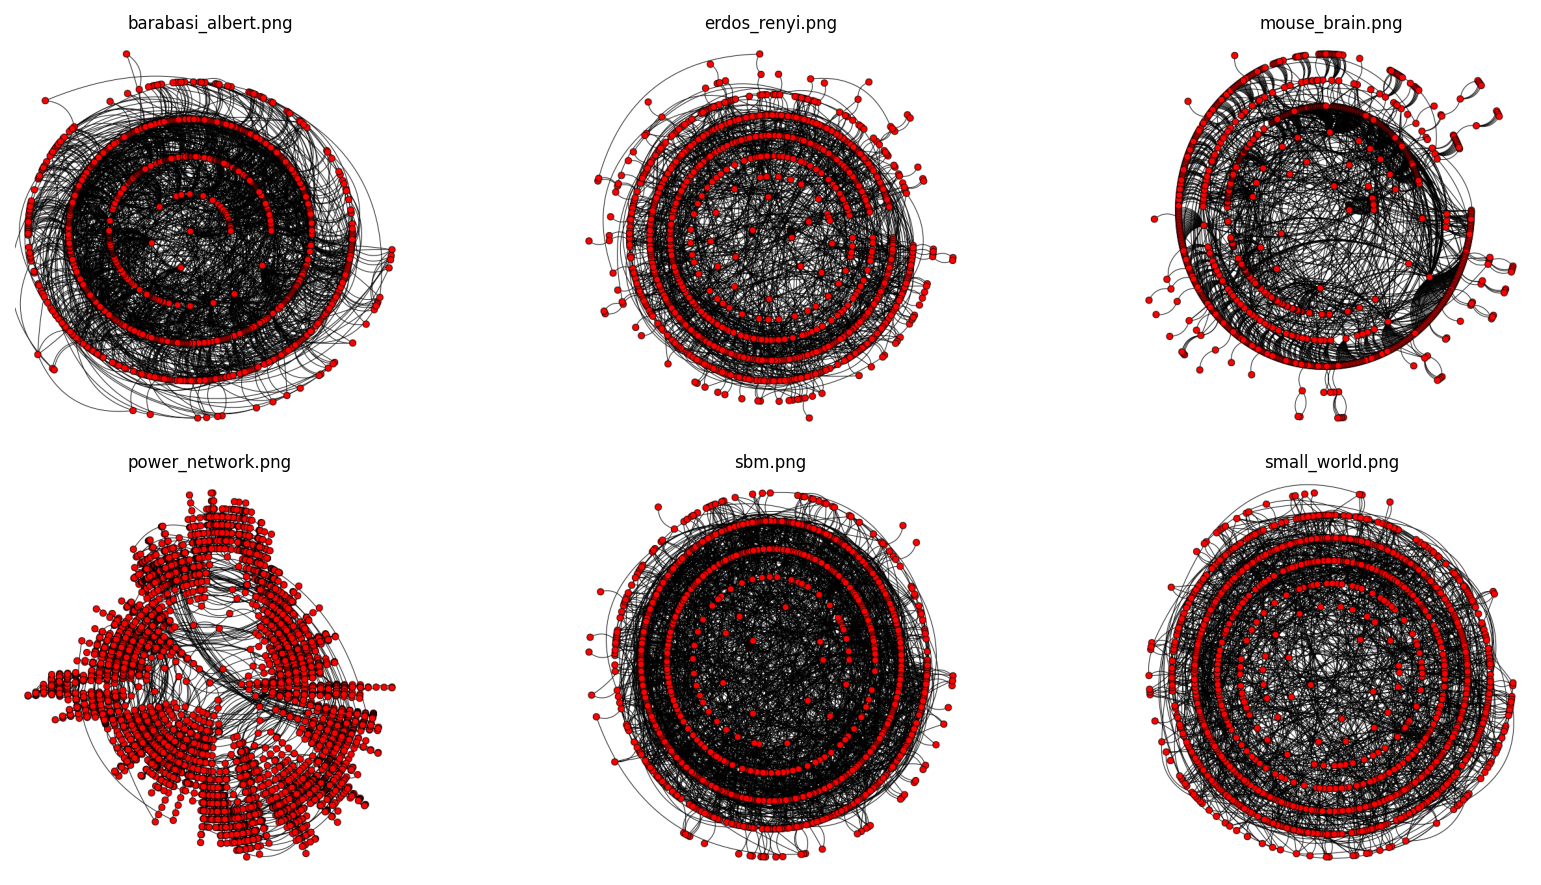

In [10]:
na.plot_images_from_folder("graphs", subplot_ratio=(2, 3), savename="all_graphs.png")

{'erdos_renyi': <igraph.Graph at 0x7114f68cca50>,
 'small_world': <igraph.Graph at 0x7114f68cd850>,
 'barabasi_albert': <igraph.Graph at 0x7114f68cd950>,
 'sbm': <igraph.Graph at 0x7114f68cda50>,
 'mouse_brain': <igraph.Graph at 0x7115435da950>,
 'power_network': <igraph.Graph at 0x711548157850>}

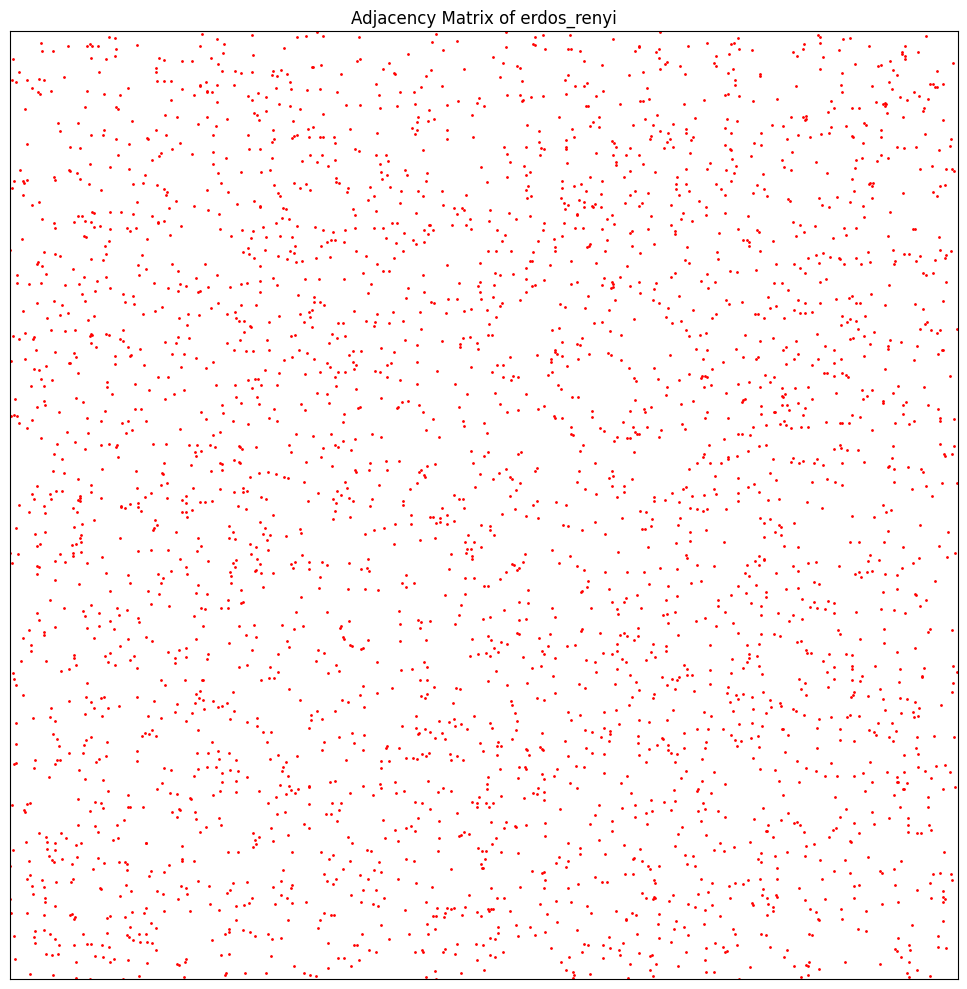

(array([  0,   1,   2, ..., 997, 998, 999]),
 array([  0,   0,   0, ..., 999, 999, 999]),
 None,
 None,
 array([    84,    119,    449, ..., 999324, 999523, 999686]))

In [24]:
graph_id = 0
na.plot_adjacency_matrix(list(graphs_collector.values())[graph_id], 
                         None,
                         label = list(graphs_collector.keys())[graph_id], 
                         no_ticks=1)

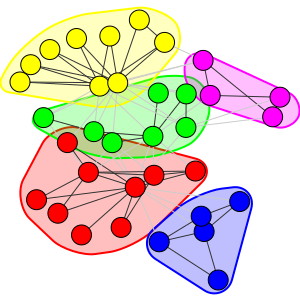

In [8]:
wtrap = g.community_walktrap(steps = 4)
clust = wtrap.as_clustering()
ig.plot(clust, mark_groups = True, bbox=(300,300))

In [ ]:

def load_city_graph_data(folder_path):
    """
    Load and print the number of edges and nodes for each city from CSV files.

    Parameters:
        folder_path (str): Path to the folder containing CSV files.
    
    Returns:
        None
    """
    # List all files in the folder
    files = os.listdir(folder_path)

    # Group files by city name
    edges_files = [f for f in files if f.endswith('_edges.csv')]
    nodes_files = [f for f in files if f.endswith('_nodes.csv')]

    # Create a dictionary to match city names with edges and nodes files
    city_data = {}
    for file in edges_files:
        city_name = file.replace('_edges.csv', '')
        city_data[city_name] = {'edges': os.path.join(folder_path, file)}

    for file in nodes_files:
        city_name = file.replace('_nodes.csv', '')
        if city_name in city_data:
            city_data[city_name]['nodes'] = os.path.join(folder_path, file)
        else:
            city_data[city_name] = {'nodes': os.path.join(folder_path, file)}

    # Load each city's data and print counts
    for city, files in city_data.items():
        edges_count = 0
        nodes_count = 0

        if 'edges' in files:
            edges_df = pd.read_csv(files['edges'])
            edges_count = len(edges_df)

        if 'nodes' in files:
            nodes_df = pd.read_csv(files['nodes'])
            nodes_count = len(nodes_df)

        print(f"City: {city}")
        print(f"  Nodes: {nodes_count}")
        print(f"  Edges: {edges_count}\n")

if __name__ == "__main__":
    folder_path = "road_nets"  # Replace with the path to your folder
    load_city_graph_data(folder_path)


City: barcelona
  Nodes: 8888
  Edges: 16503



/tmp/ipykernel_37476/3475577126.py:40: DtypeWarning: Columns (9,10,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv(files['edges'])
/tmp/ipykernel_37476/3475577126.py:44: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(files['nodes'])


City: beijing
  Nodes: 155907
  Edges: 388155



/tmp/ipykernel_37476/3475577126.py:40: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv(files['edges'])


City: berlin
  Nodes: 28137
  Edges: 73201

City: budapest
  Nodes: 24063
  Edges: 63155

City: frankfurt
  Nodes: 9554
  Edges: 20321

City: kolozsvar
  Nodes: 3142
  Edges: 7096



/tmp/ipykernel_37476/3475577126.py:40: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv(files['edges'])


City: madrid
  Nodes: 31064
  Edges: 61289

City: palma
  Nodes: 7131
  Edges: 14466

City: paris
  Nodes: 9524
  Edges: 18330



/tmp/ipykernel_37476/3475577126.py:40: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv(files['edges'])


City: rome
  Nodes: 43773
  Edges: 90763

City: taipei
  Nodes: 12109
  Edges: 28516



/tmp/ipykernel_37476/3475577126.py:40: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv(files['edges'])


City: tokyo
  Nodes: 271365
  Edges: 719191

City: viena
  Nodes: 16063
  Edges: 35808



/tmp/ipykernel_37476/3475577126.py:44: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(files['nodes'])


In [39]:
nx.katz_centrality(g.to_networkx(), normalized=0)

{0: 4.982990167874235,
 1: 3.651807952026308,
 2: 4.121404970313236,
 3: 3.02264619887899,
 4: 1.890451152885133,
 5: 2.0310725862095724,
 6: 2.0310725862095724,
 7: 2.5778843937391853,
 8: 3.1126620496103867,
 9: 1.9260736983112348,
 10: 1.890451152885133,
 11: 1.4982988513286406,
 12: 1.8005633729257626,
 13: 3.0918177426521205,
 14: 1.940525684699041,
 15: 1.940525684699041,
 16: 1.4062144432532873,
 17: 1.8634795227437637,
 18: 1.940525684699041,
 19: 2.3774128716566985,
 20: 1.940525684699041,
 21: 1.8634795227437637,
 22: 1.940525684699041,
 23: 2.5865313998191013,
 24: 1.709114957015893,
 25: 1.7301052383631466,
 26: 1.7513648061217326,
 27: 2.3556382375697504,
 28: 2.226614397415866,
 29: 2.374315200245025,
 30: 2.6169724552331104,
 31: 3.005407880187569,
 32: 4.265924794404875,
 33: 5.139335226900585}

In [28]:
np.array(list(nx.degree_centrality(g.to_networkx()).values()))*(len(g.vs)-1)

array([16.,  9., 10.,  6.,  3.,  4.,  4.,  4.,  5.,  2.,  3.,  1.,  2.,
        5.,  2.,  2.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,  5.,  3.,  3.,
        2.,  4.,  3.,  4.,  4.,  6., 12., 17.])

## Resources

All real world (not generated) graphs come from external sources. The road networks were downloaded from/with [2] and the other networks were downloaded from [1].

## Code availability

The project source code is hosted at my [GitHub](https://github.com/)


1. Rossi, R. A., & Ahmed, N. K. (2015). The Network Data Repository with Interactive Graph Analytics and Visualization. Proceedings of the AAAI Conference on Artificial Intelligence. Retrieved from https://networkrepository.com
2. Boeing, (2017), OSMnx: A Python package to work with graph-theoretic OpenStreetMap street networks, Journal of Open Source Software, 2(12), 215, doi:10.21105/joss.00215
3. Acebrón, J. A., Bonilla, L. L., Pérez Vicente, C. J., Ritort, F., & Spigler, R. (2005). The Kuramoto model: A simple paradigm for synchronization phenomena. Review of Modern Physics, 77(1), 137–185. https://doi.org/10.1103/RevModPhys.77.137
4. [Wikipedia - Kuramoto model](https://en.wikipedia.org/wiki/Kuramoto_model) 